<a href="https://colab.research.google.com/github/eyaguirat10/CoWin-Breast-Cancer-Detection/blob/eya/Eya_Guirat_Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Business Understanding

## Supervised Learning


**Business Objective**

Support early breast cancer diagnosis by providing clinicians with a decision-support tool that classifies breast lesions as benign or malignant based on Fine Needle Aspiration (FNA) measurements.

Reduce high-impact diagnostic errors:

Minimize false negatives (missed malignant tumors) to avoid delayed treatment and complications.

Limit false positives to reduce unnecessary biopsies, costs, and patient anxiety.

**Data Science Objective**

Reproduce and extend the supervised learning work from the reference paper on the Wisconsin Diagnostic Breast Cancer (WDBC) dataset.

Concretely:

Re-implement the main models used in the paper (MLP, linear SVM / L2-SVM, k-NN, softmax/logistic-type model, GRU-SVM) as baseline reference.

Then improve the pipeline with:

Rigorous evaluation (stratified k-fold cross-validation instead of a single 70/30 split).

Systematic hyperparameter search (grid/random search).

Additional supervised models that are well suited for tabular medical data (regularized logistic regression, Random Forest, Gradient Boosting models such as XGBoost/LightGBM).

**Success Criteria & Evaluation Metrics**

Primary clinical metrics (malignant class is the priority):

Sensitivity (recall on malignant) ≥ 95 %.

Specificity acceptable (≥ 90 %) to avoid too many false positives.

AUC ROC ≥ 0.95 as a global discriminative performance indicator.

Overall misclassification rate ≤ 3–5 % across cross-validation folds.

Secondary technical criteria:

Stable performance across folds (low variance of AUC / sensitivity).

Good probability calibration (calibration curve, Brier score) to make risk scores interpretable for clinicians.

Inference time < 1 second per prediction on standard hardware.


**Stakeholders**

Oncologists, radiologists, pathologists: primary users of the prediction outputs in their decision-making.

Hospital IT and data engineering teams: responsible for integration, security, and maintenance of a future tool.

Patients: indirect beneficiaries through improved diagnostic quality and triage.

Academic/research team: responsible for model development, validation, and documentation.

**Initial Model Hypothesis**

Given that the WDBC data is known to be almost linearly separable, we hypothesize that:

Regularized linear models (logistic regression, linear SVM / L2-SVM) will already achieve strong baseline performance.

Tree-based ensembles (Random Forest, Gradient Boosting) will capture non-linear interactions and may slightly improve performance and robustness compared to baselines from the paper.

A moderately sized MLP can match or exceed the MLP of the reference paper, but its added complexity must be justified by better performance and/or calibration.

The GRU-SVM architecture used in the paper is not naturally adapted to static tabular data and may not outperform simpler models; its main role in our project will be as a reproduced baseline to compare against more appropriate approaches.

## Unsupervised Learning

 **Business Objective**

Go beyond the binary benign/malignant decision by exploring the intrinsic structure of breast lesion data.

Help clinicians and researchers better understand the heterogeneity of tumors (e.g. potential sub-groups with different risk profiles or morphologic patterns) that are not explicitly modeled in the supervised paper.

 **Data Science Objective**

Apply unsupervised learning methods on the same WDBC features to:

Perform dimensionality reduction (PCA, t-SNE/UMAP) for exploratory visualization.

Perform clustering (k-means, Gaussian Mixture Models, hierarchical clustering) to identify groups of lesions.

Relate discovered clusters back to the clinical labels (benign/malignant) and key features, in order to see whether clusters correspond to:

different risk levels,

different morphological profiles,

or potential subtypes within benign or malignant lesions.

 **Success Criteria & Evaluation Metrics**

Internal clustering metrics:

Silhouette score, Davies–Bouldin index, etc., to assess cohesion and separation of clusters.

External/interpretation criteria:

Clusters with clearly different distributions of malignancy rate and of key features

Low-dimensional visualizations where clusters appear clearly distinguishable and easy to interpret for a medical audience.

Clinically plausible narratives for each cluster (“small, regular nuclei, mostly benign” vs “large, irregular, high-risk pattern”).

**Stakeholders **

Stakeholders:

Research/academic team and interested clinicians (oncologists, pathologists) who want deeper understanding of breast lesion patterns.

Potential future users designing clinical studies or risk-stratification protocols.


The interpretation of clusters must remain transparent and medically meaningful (clear profiles, not purely mathematical groups).

Same privacy and governance rules as in the supervised part (only anonymized numeric data).

**Initial Model Hypothesis**

A small number of latent dimensions (captured by PCA or similar methods) explain most of the variability in the dataset.

Simple clustering algorithms (e.g. k-means on PCA components) will already reveal:

at least one cluster strongly enriched in malignant lesions,

one or several clusters mostly benign with different morphologic characteristics.

These patterns will provide complementary insights to the supervised models and may suggest future directions (e.g. custom risk scores or tailored decision thresholds for specific sub-groups).

# II. Data Understanding

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data.csv")

In [3]:
print("Dimensions :", df.shape)
print("Colonnes :", df.columns.tolist())
print("\nTypes :", df.dtypes)

Dimensions : (569, 33)
Colonnes : ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Types : id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              

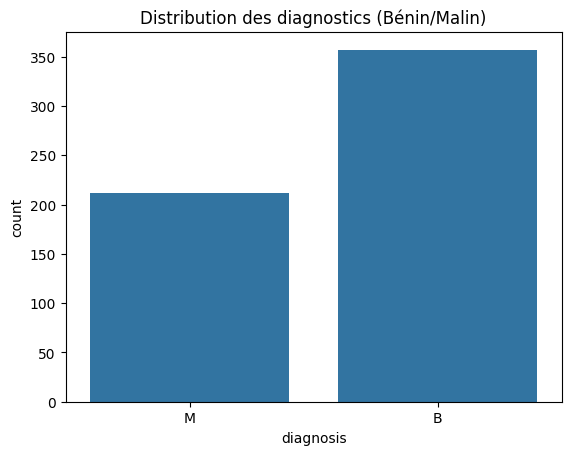

In [4]:
sns.countplot(x="diagnosis", data=df)
plt.title("Distribution des diagnostics (Bénin/Malin)")
plt.show()

In [5]:
print("\nStatistiques descriptives :")
print(df.describe())


Statistiques descriptives :
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.

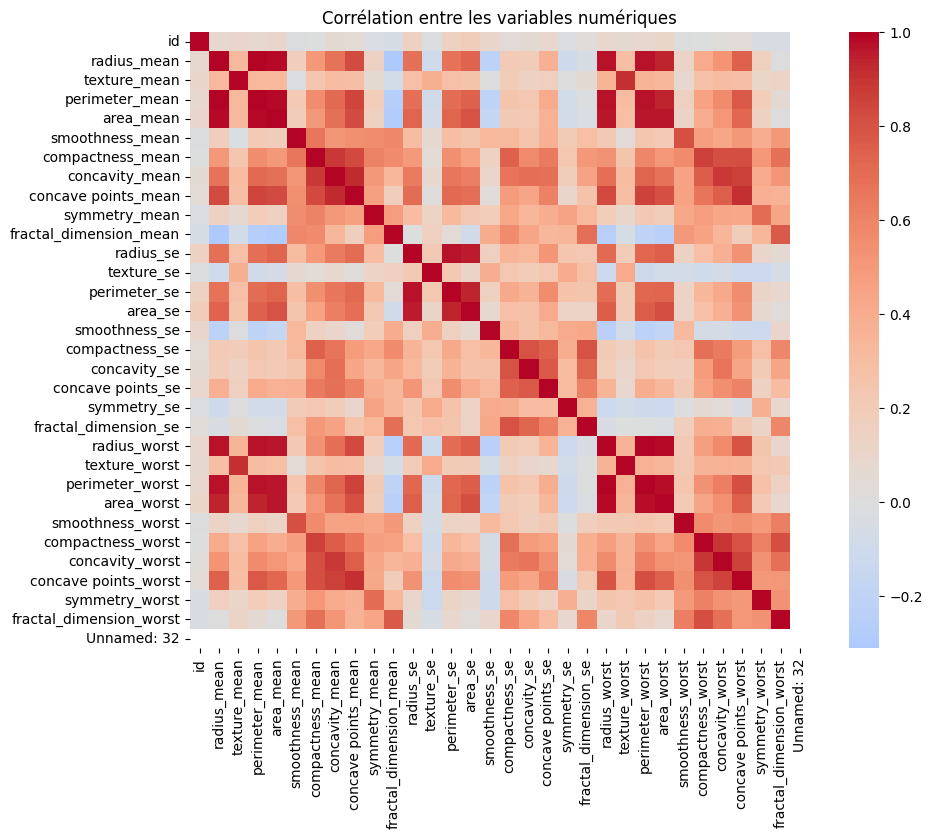

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Corrélation entre les variables numériques")
plt.show()

#III. Data Preparation

#IV. Modeling

#V. Evaluation

#VI. Deployment